In [172]:
# Step 1: Import necessary libraries

In [223]:
import warnings

In [225]:
warnings.filterwarnings('ignore')

In [226]:
pip install dash plotly

In [227]:
import dash

In [228]:
from dash import dcc, html

In [229]:
from dash.dependencies import Input, Output

In [230]:
import plotly.graph_objs as go

In [173]:
import numpy as np

In [174]:
import pandas as pd

In [175]:
import matplotlib.pyplot as plt

In [177]:
import random

In [178]:
from collections import deque

In [179]:
from tensorflow.keras.models import Model

In [180]:
from tensorflow.keras.layers import Input, Dense, Add, Lambda

In [181]:
from tensorflow.keras.optimizers import Adam

In [182]:
import tensorflow.keras.backend as K

In [183]:
# Step 2: Define the simulation environment class

In [184]:
class ClimateSimulationEnvironment:
    """
    Simulates interactions between economic activity, energy consumption,
    and greenhouse gas emissions in a climate model.
    """
    def __init__(self):
        # Initialize environment parameters
        self.economic_activity = 1.0  # Economic activity level (normalized)
        self.energy_consumption = 1.0  # Energy consumption level (normalized)
        self.greenhouse_gas_emissions = 1.0  # GHG emissions level (normalized)
        self.state = self.get_state()
        self.time_step = 0  # Track the number of steps in an episode

    def get_state(self):
        """
        Returns the current state as a vector of [economic activity, energy consumption, GHG emissions].
        """
        return np.array([self.economic_activity, self.energy_consumption, self.greenhouse_gas_emissions])

    def step(self, action):
        """
        Updates the environment based on the agent's action.

        Parameters:
            action (array): A vector representing changes in [economic activity, energy consumption].

        Returns:
            next_state (array): The updated state after applying the action.
            reward (float): The reward for the current step.
            done (bool): Whether the episode has ended.
        """
        # Apply action to update state variables
        self.economic_activity += action[0]
        self.energy_consumption += action[1]

        # Update GHG emissions based on energy consumption and economic activity
        self.greenhouse_gas_emissions += (
            0.7 * self.energy_consumption - 0.3 * self.economic_activity
        )

        # Calculate reward: balance between reducing emissions and maintaining economic growth
        reward = -self.greenhouse_gas_emissions + 0.5 * self.economic_activity

        # Check if episode is done (e.g., emissions below threshold or max steps reached)
        done = self.greenhouse_gas_emissions <= 0 or self.time_step >= 200

        # Increment time step and return results
        self.time_step += 1
        return self.get_state(), reward, done

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
            state (array): The initial state of the environment.
        """
        self.economic_activity = 1.0
        self.energy_consumption = 1.0
        self.greenhouse_gas_emissions = 1.0
        self.time_step = 0
        return self.get_state()


In [185]:
# Step 3: Define the DQN agent with prioritized experience replay

In [186]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        """
        Initializes the DQN agent with parameters for training and exploration.

        Parameters:
            state_size (int): Dimension of the state space.
            action_size (int): Dimension of the action space.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Experience replay memory size
        self.gamma = 0.95  # Discount factor for future rewards
        self.epsilon = 1.0  # Exploration rate (initially high for exploration)
        self.epsilon_decay = 0.995  # Decay rate for epsilon over time
        self.epsilon_min = 0.01  # Minimum epsilon value for exploitation
        self.learning_rate = 0.001

        # Build main and target networks with dueling architecture
        self.model = self.build_model()

    def build_model(self):
        """
        Builds a dueling DQN model to estimate Q-values.

        Returns:
            model (Keras Model): The compiled neural network model.
        """
        input_layer = Input(shape=(self.state_size,))
        hidden = Dense(32, activation='relu')(input_layer)
        value_branch = Dense(32, activation='relu')(hidden)
        advantage_branch = Dense(32, activation='relu')(hidden)

        value = Dense(1)(value_branch)
        advantage = Dense(self.action_size)(advantage_branch)

        # Dueling network output
        q_values = Add()([value, Lambda(lambda x: x - K.mean(x, axis=1, keepdims=True))(advantage)])

        model = Model(inputs=input_layer, outputs=q_values)
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        """
        Selects an action using epsilon-greedy policy.

        Parameters:
            state (array): The current state of the environment.

        Returns:
            action (array): The selected action, which is a 2-value tuple.
        """
        if np.random.rand() <= self.epsilon:
            # Return a 2-value action (change in economic activity, change in energy consumption)
            return np.random.uniform(-0.1, 0.1, size=2)  # Random action in the range [-0.1, 0.1]
        q_values = self.model.predict(state[np.newaxis, :])
        # Take the action that corresponds to the highest Q-value
        return q_values[0]  # For continuous actions, we directly return the predicted Q-values

    def replay(self, batch_size):
        """
        Updates the model by replaying experiences from memory.

        Parameters:
            batch_size (int): The size of the batch for replay.
        """
        if len(self.memory) < batch_size:
            return

        samples = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)

        states = np.array(states)
        next_states = np.array(next_states)

        targets = self.model.predict(states)
        next_q_values = self.model.predict(next_states)

        for i in range(batch_size):
            if dones[i]:
                targets[i] = rewards[i]
            else:
                targets[i] = rewards[i] + self.gamma * next_q_values[i]

        self.model.fit(states, targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [187]:
# Step 4: Implement Prioritized Experience Replay

In [188]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        max_priority = np.max(self.priorities) if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience

        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        probabilities = priorities ** alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

In [189]:
# Step 5: Main Training Loop

In [190]:
def train_agent(agent, env, episodes, steps_per_episode):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        agent.replay(64)  # Batch size of 64

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")


In [191]:
# Initialize components

In [192]:
state_size = 3  # [economic_activity, energy_consumption, greenhouse_gas_emissions]

In [193]:
action_size = 2  # [change in economic activity, change in energy consumption]


In [194]:
env = ClimateSimulationEnvironment()

In [195]:
agent = DQNAgent(state_size, action_size)

In [196]:
# Start training with a maximum of 3 episodes for faster execution

In [197]:
train_agent(agent, env, episodes=3, steps_per_episode=200)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Episode: 1, Total Reward: -14593.956205164486, Epsilon: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Episode: 2, Total Reward: -819.5129701357283, Epsilon: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Episode: 3, Total Reward: -2085.038109705713, Epsilon: 0.99


# **ELSE**

In [198]:
# Modify the training loop to track rewards and epsilon values for evaluation


In [199]:
def train_agent(agent, env, episodes, steps_per_episode):
    episode_rewards = []  # To store rewards for each episode
    epsilon_values = []   # To store epsilon values at each episode

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        agent.replay(64)  # Batch size of 64

        episode_rewards.append(total_reward)
        epsilon_values.append(agent.epsilon)

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    # After training, plot total rewards and epsilon values over episodes for evaluation
    plt.figure(figsize=(12, 6))

    # Plot total rewards per episode
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')

    # Plot epsilon values per episode
    plt.subplot(1, 2, 2)
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay per Episode')

    plt.tight_layout()
    plt.show()


In [201]:
# Start the evaluation with training for 3 episodes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Episode: 1, Total Reward: -808.0352438532492, Epsilon: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Episode: 2, Total Reward: -234.7327447338876, Epsilon: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Episode: 3, Total Reward: -312.5292719460425, Epsilon: 0.96


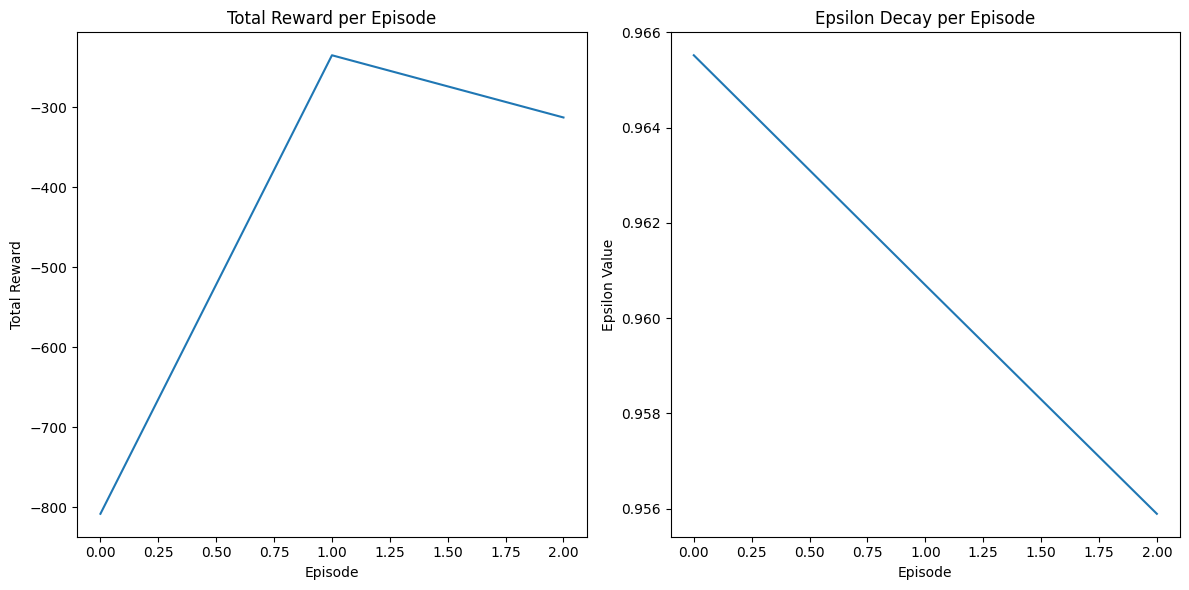

In [202]:
train_agent(agent, env, episodes=3, steps_per_episode=200)

# **CREATING AN INTERACTIVE DASHBOARD**

In [206]:
# Initialize Dash app

In [207]:
app = dash.Dash(__name__)

In [208]:
# Set up initial data for the plot

In [209]:
episode_rewards = []  # To store rewards for each episode

In [210]:
epsilon_values = []   # To store epsilon values at each episode

In [211]:
# Dummy function for simulation (you can replace with your model)

In [212]:
def simulate_episode(agent, env, episodes=3, steps_per_episode=200):
    global episode_rewards, epsilon_values
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for step in range(steps_per_episode):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            if done:
                break
        agent.replay(64)
        episode_rewards.append(total_reward)
        epsilon_values.append(agent.epsilon)

In [213]:
# Layout of the dashboard

In [214]:
app.layout = html.Div([
    html.H1("Climate Simulation and Agent Training Dashboard"),

    # Dropdown for selecting the number of episodes
    html.Label("Select Number of Episodes:"),
    dcc.Dropdown(
        id='episodes-dropdown',
        options=[{'label': str(i), 'value': i} for i in range(1, 11)],
        value=3,
    ),

    # Graph for total rewards per episode
    dcc.Graph(id='reward-graph'),

    # Graph for epsilon decay per episode
    dcc.Graph(id='epsilon-graph'),

    # Button to trigger the simulation
    html.Button('Start Simulation', id='start-button', n_clicks=0),
])

# Update graphs based on the selected number of episodes
@app.callback(
    [Output('reward-graph', 'figure'),
     Output('epsilon-graph', 'figure')],
    [Input('start-button', 'n_clicks'),
     Input('episodes-dropdown', 'value')]
)
def update_dashboard(n_clicks, num_episodes):
    if n_clicks > 0:
        # Simulate with the specified number of episodes
        # Replace 'agent' and 'env' with your actual agent and environment
        simulate_episode(agent, env, episodes=num_episodes, steps_per_episode=200)

        # Create the total reward graph
        reward_fig = {
            'data': [go.Scatter(x=np.arange(len(episode_rewards)), y=episode_rewards, mode='lines+markers')],
            'layout': go.Layout(title='Total Reward per Episode',
                                xaxis={'title': 'Episode'},
                                yaxis={'title': 'Total Reward'})
        }

        # Create the epsilon graph
        epsilon_fig = {
            'data': [go.Scatter(x=np.arange(len(epsilon_values)), y=epsilon_values, mode='lines+markers')],
            'layout': go.Layout(title='Epsilon Decay per Episode',
                                xaxis={'title': 'Episode'},
                                yaxis={'title': 'Epsilon Value'})
        }

        return reward_fig, epsilon_fig
    else:
        # Return empty graphs when simulation is not started
        return {}, {}

In [215]:
# Run the Dash app

In [217]:
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>